# Import packages

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Read data

In [112]:
df_data = pd.read_csv("../dataset/adult.csv")

In [113]:
df_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [114]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   fnlwgt           32561 non-null  int64 
 3   education        32561 non-null  object
 4   educational-num  32561 non-null  int64 
 5   marital-status   32561 non-null  object
 6   occupation       32561 non-null  object
 7   relationship     32561 non-null  object
 8   race             32561 non-null  object
 9   gender           32561 non-null  object
 10  capital-gain     32561 non-null  int64 
 11  capital-loss     32561 non-null  int64 
 12  hours-per-week   32561 non-null  int64 
 13  native-country   32561 non-null  object
 14  income           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Check Nulls and replace missing/wrong values

In [115]:
# drop unused columns
df_data = df_data.drop(['fnlwgt', 'educational-num'], axis = 1) 

In [116]:
# Remove All Spaces from Strings in a DataFrame
df_data = df_data.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

In [117]:
# col_names = df_data.select_dtypes("object").columns
col_names = df_data.columns

# Replace "?" with NaN
df_data.replace("?", np.nan, inplace=True)

# Replace "Hong" with "HongKong"
df_data['native-country'] = df_data['native-country'].replace("Hong", "Hong-Kong")

# Fill NaN values with the mode of each column
for c in col_names:
    if df_data[c].isnull().any():  # Check if the column has missing values
        mode_value = df_data[c].mode()[0]  # Get the most frequent value (mode)
        df_data[c] = df_data[c].fillna(mode_value)

In [118]:
df_data.duplicated().sum()

np.int64(3591)

In [119]:
# drop duplicates rows
df_data.drop_duplicates(inplace=True)

In [120]:
df_data.duplicated().sum()

np.int64(0)

In [121]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28970 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             28970 non-null  int64 
 1   workclass       28970 non-null  object
 2   education       28970 non-null  object
 3   marital-status  28970 non-null  object
 4   occupation      28970 non-null  object
 5   relationship    28970 non-null  object
 6   race            28970 non-null  object
 7   gender          28970 non-null  object
 8   capital-gain    28970 non-null  int64 
 9   capital-loss    28970 non-null  int64 
 10  hours-per-week  28970 non-null  int64 
 11  native-country  28970 non-null  object
 12  income          28970 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.1+ MB


# Encoding

In [123]:
le = LabelEncoder()

# Define the categorical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'gender', 'native-country']

# Initialize a dictionary to store the encoders
encoders = {col: LabelEncoder() for col in categorical_columns}

# Fit encoders on training data or known categories
for col in categorical_columns:
    # Assuming `df[col]` is the training data for each feature
    df_data[col] = encoders[col].fit_transform(df_data[col])

for col, encoder in encoders.items():
    print(f"Mappings for {col}:")
    print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


Mappings for workclass:
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Never-worked': np.int64(2), 'Private': np.int64(3), 'Self-emp-inc': np.int64(4), 'Self-emp-not-inc': np.int64(5), 'State-gov': np.int64(6), 'Without-pay': np.int64(7)}
Mappings for education:
{'10th': np.int64(0), '11th': np.int64(1), '12th': np.int64(2), '1st-4th': np.int64(3), '5th-6th': np.int64(4), '7th-8th': np.int64(5), '9th': np.int64(6), 'Assoc-acdm': np.int64(7), 'Assoc-voc': np.int64(8), 'Bachelors': np.int64(9), 'Doctorate': np.int64(10), 'HS-grad': np.int64(11), 'Masters': np.int64(12), 'Preschool': np.int64(13), 'Prof-school': np.int64(14), 'Some-college': np.int64(15)}
Mappings for marital-status:
{'Divorced': np.int64(0), 'Married-AF-spouse': np.int64(1), 'Married-civ-spouse': np.int64(2), 'Married-spouse-absent': np.int64(3), 'Never-married': np.int64(4), 'Separated': np.int64(5), 'Widowed': np.int64(6)}
Mappings for occupation:
{'Adm-clerical': np.int64(0), 'Armed-Forces': np.int64(1), 'Cra

In [124]:
# Save the encoders dictionary to a .pkl file
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("Encoders have been saved to 'encoders.pkl'")

Encoders have been saved to 'encoders.pkl'


In [125]:
df_data['income'] = le.fit_transform(df_data['income'])

# Exploratory Data Analysis

Text(0.5, 1.0, '<=50K Income vs >50K Income Count')

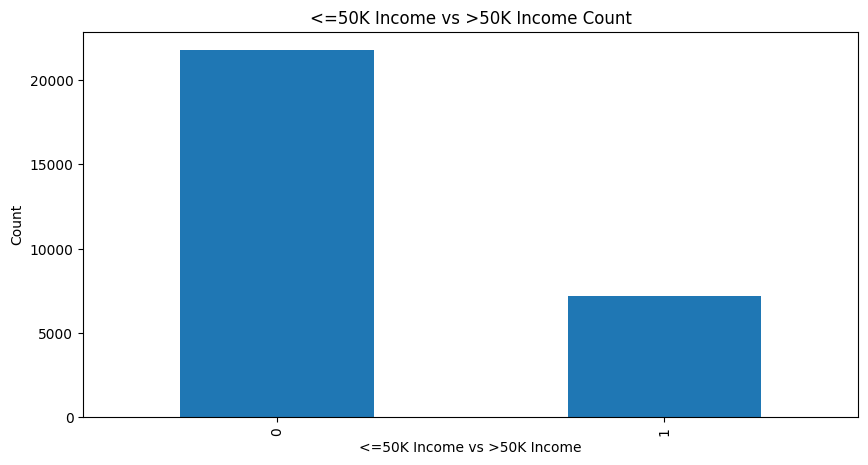

In [126]:
# Plot Fraud vs Non-fraud cases
plt.figure(figsize=(10,5))
ax = df_data.income.value_counts().plot(kind = 'bar')
plt.xlabel("<=50K Income vs >50K Income")
plt.ylabel("Count")
plt.title("<=50K Income vs >50K Income Count")

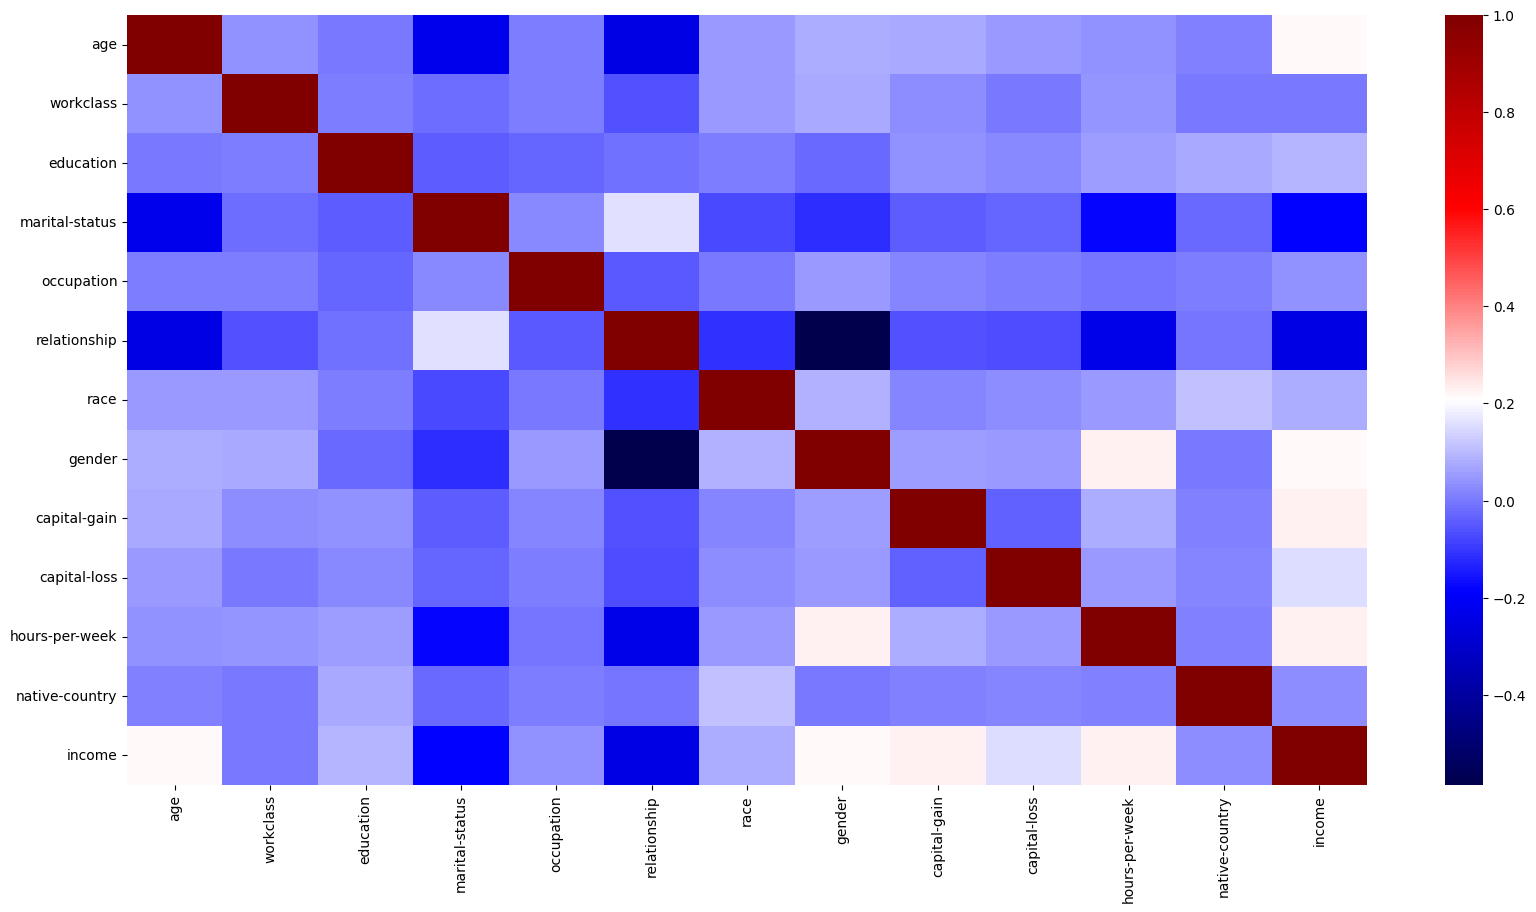

In [127]:
# Heatmap to find any high correlations
plt.figure(figsize=(20,10))
sns.heatmap(data=df_data.corr(), cmap="seismic")
plt.show()

# Label Data

In [128]:
X = df_data.drop('income', axis = 1).to_numpy()
Y = df_data['income']

# Train & Test Data using Random Forest, AdaBoost, and Gradient Boosting Classifier

In [129]:
# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Define scoring metrics
scoring_metrics = ['accuracy', 'recall', 'precision', 'roc_auc']

# Store results for each classifier
results = {}

for clf_name, clf in classifiers.items():
    print(f"\nEvaluating {clf_name}...")
    
    clf_results = {}
    for metric in scoring_metrics:
        # Cross-validation score for each metric
        cv_score = cross_val_score(clf, X, Y, cv=cv, scoring=metric)
        clf_results[metric] = np.mean(cv_score)
    
    results[clf_name] = clf_results

# Print results
for clf_name, clf_results in results.items():
    print(f"\n{clf_name} Results:")
    for metric, score in clf_results.items():
        print(f"{metric.capitalize()}: {score:.4f}")


Evaluating Random Forest...

Evaluating AdaBoost...

Evaluating Gradient Boosting...

Random Forest Results:
Accuracy: 0.8354
Recall: 0.5975
Precision: 0.6955
Roc_auc: 0.8851

AdaBoost Results:
Accuracy: 0.8378
Recall: 0.5305
Precision: 0.7428
Roc_auc: 0.8976

Gradient Boosting Results:
Accuracy: 0.8607
Recall: 0.6057
Precision: 0.7832
Roc_auc: 0.9181


# Fit the model using Gradient Boosting Classifier

In [130]:
# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Cross-validation scores for accuracy
cv_accuracy = cross_val_score(gbc, X, Y, cv=cv, scoring='accuracy')
cv_recall = cross_val_score(gbc, X, Y, cv=cv, scoring='recall')
cv_precision = cross_val_score(gbc, X, Y, cv=cv, scoring='precision')
cv_roc_auc = cross_val_score(gbc, X, Y, cv=cv, scoring='roc_auc')

print("Cross-validation Accuracy: ", np.mean(cv_accuracy))
print("Cross-validation Recall: ", np.mean(cv_recall))
print("Cross-validation Precision: ", np.mean(cv_precision))
print("Cross-validation ROC AUC: ", np.mean(cv_roc_auc))

Cross-validation Accuracy:  0.860717984121505
Cross-validation Recall:  0.6057103064066853
Cross-validation Precision:  0.7832227345002104
Cross-validation ROC AUC:  0.918141403572465


In [131]:
gbc.fit(X, Y)

GradientBoostingClassifier(random_state=42)

# Save Model

In [132]:
model_out = open("model.pkl", "wb")
pickle.dump(gbc, model_out)
model_out.close()